# Named entity recognition with Bert TF 2.X

Named Enity Recognition is one of the most common NLP problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. What can you use it for? Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining!

Let's start by importing some packages.

## Transformers
Implementations of pre-trained BERT models already exist in TensorFlow due to its popularity. I leveraged the popular transformers library while building out this project.

In [ ]:
!pip install transformers

First, you install the transformers package by huggingface. This library contains some state-of-the-art pre-trained models for Natural Language Processing (NLP) like BERT, GPT, XLNet … etc.

Now you have access to the pre-trained Bert models and the TensorFlow wrappers we will use here. 

In [2]:
files_path = "./"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tqdm import tqdm,trange

# Data

Let's take a look at data. [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [4]:
data = pd.read_csv(f"{files_path}ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-gpe', 'B-per', 'I-geo', 'I-eve', 'O', 'B-tim', 'B-geo', 'I-tim', 'I-nat', 'B-art', 'I-art', 'B-nat', 'B-eve', 'I-org', 'B-org', 'B-gpe', 'I-per']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


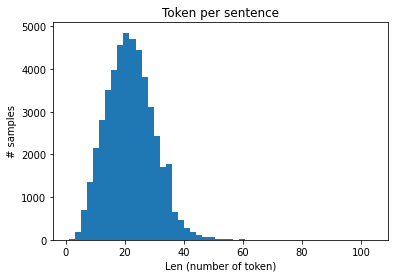

In [6]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.

* We will use the word2idx dictionary to convert each word to a corresponding integer ID and the tag2idx to do the same for the labels. Representing words as integers saves a lot of memory!
* In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.
The *Tokens per sentence* plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [7]:
tag_list=data.Tag.unique()

X = [[w[0] for w in s] for s in sentences]
y = [[w[2] for w in s] for s in sentences]

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
np.array(X_tr).shape, np.array(X_te).shape, np.array(y_tr).shape, np.array(y_te).shape

((43163,), (4796,), (43163,), (4796,))

# Training Parameters
We'll set the hyperparameters for training our model.

In [8]:
MAX_LENGTH=128
BERT_MODEL="bert-base-cased"

BATCH_SIZE=32

pad_token=0,
pad_token_segment_id=0,
sequence_a_segment_id=0,

## Tokenizer

The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [36]:
from transformers import (
    TF2_WEIGHTS_NAME,
    BertConfig,
    BertTokenizer,
    TFBertForTokenClassification,
    create_optimizer,BertForSequenceClassification)

In [10]:
MODEL_CLASSES = {"bert": (BertConfig, TFBertForTokenClassification, BertTokenizer)}

In [11]:
label_map = {label: i for i, label in enumerate(tag_list)}

In [12]:
num_labels = len(tag_list) + 1
num_labels

18

In [13]:
pad_token_label_id = 0

## Create a Model
NER is the multi-class classification problem where the words are our input and tags are our labels. The transformers package provides a TFBertForTokenClassification class for token-level predictions.TFBertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. We load the pre-trained “bert-base-cased” model and provide the number of possible labels.

In [14]:
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [15]:
config = config_class.from_pretrained(BERT_MODEL,num_labels=num_labels)

In [16]:
tokenizer = tokenizer_class.from_pretrained(BERT_MODEL,do_lower_case=False)

In [17]:
model = model_class.from_pretrained(
                BERT_MODEL,
                from_pt=bool(".bin" in BERT_MODEL),
                config=config)

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertForTokenClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
 model.layers[-1].activation = tf.keras.activations.softmax

### Prepare Input
Before we can start fine-tuning the model, we have to prepare the data set for use with BERT. We need to set the text into 3 kinds of embeddings:

#### Token embedding
In order to make token embedding, we need to map the word token into the id.

#### Attention Mask
In order to make mask word embedding, we need to use 1 to indicate the real toke and 0 to indicate to pad token.

In [19]:
from keras.preprocessing.sequence import pad_sequences
max_seq_length =128

def convert_to_input(sentences,tags):
    # Where “token_type_ids” are used to indicate whether this is the first sequence or the second sequence.
    input_id_list,attention_mask_list,token_type_id_list=[],[],[]
    label_id_list=[]
  
    for x,y in tqdm(zip(sentences,tags),total=len(tags)):
  
        tokens = []
        label_ids = []

        for word, label in zip(x, y):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          # Use the real label id for the first token of the word, and padding ids for the remaining tokens
          label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))


        special_tokens_count =  2
        if len(tokens) > max_seq_length - special_tokens_count:
          tokens = tokens[: (max_seq_length - special_tokens_count)]
          label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        label_ids = [pad_token_label_id]+label_ids+[pad_token_label_id]
        inputs = tokenizer.encode_plus(tokens,add_special_tokens=True, max_length=max_seq_length,truncation=True)

        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]
        attention_masks = [1] * len(input_ids)

        attention_mask_list.append(attention_masks)
        input_id_list.append(input_ids)
        token_type_id_list.append(token_type_ids)

        label_id_list.append(label_ids)

    return input_id_list,token_type_id_list,attention_mask_list,label_id_list

Using TensorFlow backend.


In [20]:
input_ids_train,token_ids_train,attention_masks_train,label_ids_train=convert_to_input(X_tr,y_tr)

100%|██████████| 43163/43163 [00:51<00:00, 838.00it/s]


In [21]:
input_ids_test,token_ids_test,attention_masks_test,label_ids_test=convert_to_input(X_te,y_te)

100%|██████████| 4796/4796 [00:05<00:00, 861.69it/s]


Next, we cut and pad the token and label sequences to our desired length.

In [22]:
input_ids_train = pad_sequences(input_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
token_ids_train = pad_sequences(token_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
attention_masks_train = pad_sequences(attention_masks_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
label_ids_train = pad_sequences(label_ids_train,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")

In [23]:
np.shape(input_ids_train),np.shape(token_ids_train),np.shape(attention_masks_train),np.shape(label_ids_train),

((43163, 128), (43163, 128), (43163, 128), (43163, 128))

In [24]:
input_ids_test = pad_sequences(input_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
token_ids_test = pad_sequences(token_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
attention_masks_test = pad_sequences(attention_masks_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")
label_ids_test = pad_sequences(label_ids_test,maxlen=max_seq_length,dtype="long",truncating="post",padding="post")

In [25]:
np.shape(input_ids_test),np.shape(token_ids_test),np.shape(attention_masks_test),np.shape(label_ids_test),

((4796, 128), (4796, 128), (4796, 128), (4796, 128))

The last step is to define tf.data.dataset. We shuffle the data at training time and at test time we just pass them sequentially.

In [26]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
    return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y

train_ds = tf.data.Dataset.from_tensor_slices((input_ids_train,attention_masks_train,token_ids_train,label_ids_train)).map(example_to_features).shuffle(1000).batch(32).repeat(5)


test_ds=tf.data.Dataset.from_tensor_slices((input_ids_test,attention_masks_test,token_ids_test,label_ids_test)).map(example_to_features).batch(1)


In [27]:
for x,y in test_ds.take(5):
    print(x,y)

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int64, numpy=
array([[  101,  3788,  2686,  1121,  1103,  1347,  1407,  2992,   117,
         1134,  1145,  4102,  5586, 13298,   117,  1132,  1496,  1118,
         1357,  1659,   117,  1170, 11344,  1132, 10456,   119,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [28]:
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  13842     
Total params: 108,324,114
Trainable params: 108,324,114
Non-trainable params: 0
_________________________________________________________________


In [29]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [30]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train Model

Train the model for 3 epochs in mini-batches of 32 samples. This is 3 iterations over all samples in the train_ds and test_ds tensors. While training, monitor the model’s loss and accuracy on the samples from the validation set.

In [ ]:
history = model.fit(train_ds, epochs=1, validation_data=test_ds)

6745/6745 [==============================] - 5993s 888ms/step - loss: 2.0077 - accuracy: 0.9738 - val_loss: 2.0077 - val_accuracy: 0.9738


In [ ]:
# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained(f'{files_path}')

# Training & Evaluate
*Note:* Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict **'O'** or **'PAD'** without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the **precision**, **recall** and **f1-score** for each of the Tags.

In [32]:
model.load_weights(f'{files_path}tf_model.h5')

In [ ]:
# hist = pd.DataFrame(history.history)

In [106]:
# plt.style.use("ggplot")
# plt.figure(figsize=(12, 12))
# plt.plot(hist["accuracy"])
# plt.plot(hist["val_accuracy"])
# plt.show()

In [35]:
results = model.evaluate(test_ds)
print(results)

4796/4796 [==============================] - 292s 61ms/step - loss: 2.0076 - accuracy: 0.9739
[2.0075690746307373, 0.9739007949829102]


# References

[Named entity recognition with Bert
](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)

[Name Entity Recognition with BERT in TensorFlow](https://androidkt.com/name-entity-recognition-with-bert-in-tensorflow/)

[Transformers: State-of-the-art Natural Language Processing for Pytorch and TensorFlow 2.0.](https://github.com/huggingface/transformers)